In [8]:
import numpy as np
import numpy
import pyscf
import pyscf.gto
import pyscf.qmmm
import pyscf.scf
import pyscf.dft
import pyscf.lib
from pyscf.data import nist
import qml
import sys
sys.path.insert(0,'/home/misa/git_repositories/APDFT/prototyping/atomic_energies/')
import utils_qm as ut

angstrom = 1 / 0.52917721067

ModuleNotFoundError: No module named 'utils_qm'

In [2]:
com = qml.Compound(xyz='/home/misa/datasets/qm9/dsgdb9nsd_001212.xyz')
total_elec = com.nuclear_charges.sum()
num_elecs = [22, 30, 38, 44, 52]
alchemical_potentials = []
e_homo = []
e_lumo = []

for num_elec in num_elecs:
    print(f'Calculating {num_elec}')
    lam_val = num_elec/total_elec
    # core_elec = com.nuclear_charges.sum() - total_num_ve

    mol = pyscf.gto.Mole()
    for ch, coords in zip(com.nuclear_charges, com.coordinates):
        mol.atom.append([ch, coords])

    mol.basis = 'def2-tzvp'
    print(total_elec - num_elec)
    mol.charge = total_elec - num_elec
    mol.verbose = 4
    mol.build()

    method = "HF"
    if method not in ["CCSD", "HF"]:
        raise NotImplementedError("Method %s not supported." % method)

    deltaZ = -com.nuclear_charges*(1-lam_val)
    includeonly = np.arange(len(mol.atom_coords()))


    def add_qmmm(calc, mol, deltaZ):
        mf = pyscf.qmmm.mm_charge(calc, mol.atom_coords()[includeonly]/ angstrom, deltaZ)

        def energy_nuc(self):
            q = mol.atom_charges().astype(np.float)
            q[includeonly] += deltaZ
            return mol.energy_nuc(q)

        mf.energy_nuc = energy_nuc.__get__(mf, mf.__class__)

        return mf

    if method == "HF":
        calc = add_qmmm(pyscf.scf.RHF(mol), mol, deltaZ)
        hfe = calc.kernel(verbose=0)
        dm1_ao = calc.make_rdm1()
        total_energy = calc.e_tot
    if method == "CCSD":
        calc = add_qmmm(pyscf.scf.RHF(mol), mol, deltaZ)
        hfe = calc.kernel(verbose=0)
        mycc = pyscf.cc.CCSD(calc).run()
        dm1 = mycc.make_rdm1()
        dm1_ao = np.einsum("pi,ij,qj->pq", calc.mo_coeff, dm1, calc.mo_coeff.conj())
        total_energy = mycc.e_tot

    # GRIDLESS, as things should be ############################
    # Total energy of SCF run

    print("TOTAL_ENERGY", total_energy)

    # Electronic EPN from electron density
    alch_pot_tmp = []
    for site in includeonly:
        mol.set_rinv_orig_(mol.atom_coords()[site])
#         print("ELECTRONIC_EPN", site, np.matmul(dm1_ao, mol.intor("int1e_rinv")).trace())
        alch_pot_tmp.append(np.matmul(dm1_ao, mol.intor("int1e_rinv")).trace())
    alchemical_potentials.append(alch_pot_tmp)
    
    # energy of HOMO and LUMO
    nocc = int((total_elec - mol.charge)/2)
    e_homo.append(calc.mo_energy[nocc-1])
    e_lumo.append(calc.mo_energy[nocc])

Calculating 22
30
System: uname_result(system='Linux', node='pc-avl24', release='4.15.0-108-generic', version='#109-Ubuntu SMP Fri Jun 19 11:33:10 UTC 2020', machine='x86_64', processor='x86_64')  Threads 8
Python 3.7.3 (default, Mar 27 2019, 22:11:17) 
[GCC 7.3.0]
numpy 1.16.4  scipy 1.2.1
Date: Thu Jun 25 16:21:07 2020
PySCF version 1.7.1
PySCF path  /home/misa/anaconda3/envs/atomic-energies/lib/python3.7/site-packages/pyscf

[CONFIG] conf_file None
[INPUT] verbose = 4
[INPUT] num. atoms = 12
[INPUT] num. electrons = 22
[INPUT] charge = 30
[INPUT] spin (= nelec alpha-beta = 2S) = 0
[INPUT] symmetry False subgroup None
[INPUT] Mole.unit = angstrom
[INPUT]  1 C     -0.136883959200   1.448579793000   0.011368940800 AA   -0.258673193734   2.737419078349   0.021484184438 Bohr
[INPUT]  2 C      0.064357729200  -0.043732595200   0.001817971000 AA    0.121618482187  -0.082642627644   0.003435467292 Bohr
[INPUT]  3 O      1.114424575900  -0.629340888600  -0.012303871000 AA    2.105957234936  

Overwritten attributes  energy_nuc  of <class 'pyscf.qmmm.itrf.qmmm_for_scf.<locals>.QMMM'>


init E= 217.021850274313
  HOMO = 4.99480993985172  LUMO = 5.05535175096814


/home/misa/anaconda3/envs/atomic-energies/lib/python3.7/site-packages/pyscf/gto/mole.py:1047: UserWarning: Function mol.dumps drops attribute charge because it is not JSON-serializable
  warnings.warn(msg)


cycle= 1 E= 18.22951293685  delta_E= -199  |g|=    3  |ddm|= 2.93e+03
  HOMO = -3.20597898416848  LUMO = -2.90640058424898
cycle= 2 E= -34.4280364571176  delta_E= -52.7  |g|= 6.19  |ddm|= 2.92e+03
  HOMO = -2.98896083270615  LUMO = -2.6947158240307
cycle= 3 E= -35.0933217478795  delta_E= -0.665  |g|=  5.9  |ddm|=  0.6
  HOMO = -2.91664527796744  LUMO = -2.61322119060847
cycle= 4 E= -35.3506091789893  delta_E= -0.257  |g|=  5.8  |ddm|= 0.288
  HOMO = -2.91445012278694  LUMO = -2.60716447233896
cycle= 5 E= -35.3386223839741  delta_E= 0.012  |g|=  5.8  |ddm|= 0.0373
  HOMO = -2.8819573128793  LUMO = -2.57739633851608
cycle= 6 E= -35.4301342407011  delta_E= -0.0915  |g|= 5.75  |ddm|= 0.175
  HOMO = -2.88261369491678  LUMO = -2.57822432524959
cycle= 7 E= -35.4266225876827  delta_E= 0.00351  |g|= 5.76  |ddm|= 0.00842
  HOMO = -2.83310372525517  LUMO = -2.52961464478397
cycle= 8 E= -35.5768231790122  delta_E= -0.15  |g|= 5.68  |ddm|= 0.163
  HOMO = -2.83421400571779  LUMO = -2.53046463203295


cycle= 11 E= -95.7521268456739  delta_E= -0.000629  |g|= 0.00769  |ddm|= 0.289
  HOMO = -0.256456900040861  LUMO = -0.0654871767151265
cycle= 12 E= -95.752220079697  delta_E= -9.32e-05  |g|= 0.00293  |ddm|= 0.187
  HOMO = -0.256646914493376  LUMO = -0.0654246859446094
cycle= 13 E= -95.7522362966511  delta_E= -1.62e-05  |g|= 0.00263  |ddm|= 0.0458
  HOMO = -0.256708848730027  LUMO = -0.0652944027042203
cycle= 14 E= -95.7522483967607  delta_E= -1.21e-05  |g|= 0.00196  |ddm|= 0.0304
  HOMO = -0.25692708063384  LUMO = -0.0651968501029022
cycle= 15 E= -95.752264729448  delta_E= -1.63e-05  |g|= 0.00114  |ddm|= 0.0376
  HOMO = -0.257011084109002  LUMO = -0.0651783507967802
cycle= 16 E= -95.7522718311783  delta_E= -7.1e-06  |g|= 0.00105  |ddm|= 0.0196
  HOMO = -0.257247833336393  LUMO = -0.0652550008242409
cycle= 17 E= -95.752286895691  delta_E= -1.51e-05  |g|= 0.000793  |ddm|= 0.054
  HOMO = -0.257382742054053  LUMO = -0.0652227595477461
cycle= 18 E= -95.752293713515  delta_E= -6.82e-06  |g|=

cycle= 16 E= -169.200443574805  delta_E= -0.0244  |g|= 0.0913  |ddm|= 0.447
  HOMO = -0.30930139887153  LUMO = -0.0814625588875189
cycle= 17 E= -169.208882790394  delta_E= -0.00844  |g|= 0.0439  |ddm|= 0.306
  HOMO = -0.309792114804736  LUMO = -0.0814331070605606
cycle= 18 E= -169.210956483747  delta_E= -0.00207  |g|= 0.0204  |ddm|= 0.157
  HOMO = -0.312548457772289  LUMO = -0.0823176461452475
cycle= 19 E= -169.21155640479  delta_E= -0.0006  |g|= 0.0096  |ddm|= 0.0894
  HOMO = -0.311971010080536  LUMO = -0.0817779838967219
cycle= 20 E= -169.211728008529  delta_E= -0.000172  |g|= 0.00472  |ddm|= 0.0464
  HOMO = -0.31215931186943  LUMO = -0.0816501436293024
cycle= 21 E= -169.211779581163  delta_E= -5.16e-05  |g|= 0.00292  |ddm|= 0.0244
  HOMO = -0.312210068657444  LUMO = -0.081946561717093
cycle= 22 E= -169.21180321842  delta_E= -2.36e-05  |g|= 0.00179  |ddm|= 0.0187
  HOMO = -0.312129741480518  LUMO = -0.0818687649606047
cycle= 23 E= -169.211814457223  delta_E= -1.12e-05  |g|= 0.00117  

  HOMO = -0.378167702098848  LUMO = -0.174307584594529
cycle= 10 E= -240.439417245705  delta_E= -0.165  |g|= 0.392  |ddm|= 0.751
  HOMO = -0.39330725740089  LUMO = -0.176581095487131
cycle= 11 E= -240.478733127182  delta_E= -0.0393  |g|= 0.32  |ddm|= 0.259
  HOMO = -0.394614309305739  LUMO = -0.165655346881402
cycle= 12 E= -240.508706812488  delta_E= -0.03  |g|= 0.229  |ddm|= 0.323
  HOMO = -0.376753970553164  LUMO = -0.167769411455298
cycle= 13 E= -240.534767758625  delta_E= -0.0261  |g|= 0.121  |ddm|= 0.676
  HOMO = -0.369015950732262  LUMO = -0.170681891500391
cycle= 14 E= -240.543743465236  delta_E= -0.00898  |g|= 0.0484  |ddm|= 0.449
  HOMO = -0.367054775069854  LUMO = -0.169140947124878
cycle= 15 E= -240.546060776087  delta_E= -0.00232  |g|= 0.018  |ddm|= 0.202
  HOMO = -0.36787290944445  LUMO = -0.166485518390925
cycle= 16 E= -240.546605990708  delta_E= -0.000545  |g|= 0.0103  |ddm|= 0.0722
  HOMO = -0.370675489969787  LUMO = -0.165510141199045
cycle= 17 E= -240.546833374009  de

  HOMO = -0.470015531167038  LUMO = 0.117421266574001
cycle= 10 E= -358.701270379052  delta_E= -4.97e-08  |g|= 8.39e-05  |ddm|= 0.00062
  HOMO = -0.470014715741997  LUMO = 0.117422711744952
cycle= 11 E= -358.701270383211  delta_E= -4.16e-09  |g|= 2.76e-05  |ddm|= 0.000189
  HOMO = -0.47001838293533  LUMO = 0.117421290362642
cycle= 12 E= -358.701270383614  delta_E= -4.02e-10  |g|= 1.04e-05  |ddm|= 4.6e-05
  HOMO = -0.470018013000769  LUMO = 0.117421878412091
Extra cycle  E= -358.701270383676  delta_E= -6.25e-11  |g|= 7.28e-06  |ddm|= 1.18e-05
converged SCF energy = -358.701270383676
TOTAL_ENERGY -358.7012703836761


In [3]:
e_homo

[-0.1749114456153084,
 -0.25773431164544425,
 -0.3120810982897193,
 -0.37219370613595987,
 -0.470018013000769]

In [4]:
e_lumo

[-0.024839642792592757,
 -0.0652063328538395,
 -0.08175936725895919,
 -0.16351273977629224,
 0.11742187841209135]

In [13]:
base = '/home/misa/APDFT/prototyping/atomic_energies/results/different_resevoir/pyscf/com_001212/'
save_obj(alchemical_potentials, base+'alch_pots')
save_obj(e_homo, base+'e_homo')
save_obj(e_lumo, base+'e_lumo')

In [ ]:
### Plot results

In [22]:
from matplotlib import pyplot as plt
import numpy as np

In [ ]:
### load data

In [14]:
def load_obj(fname):
    with open(fname, 'rb') as f:
        return pickle.load(f)

In [17]:
base = '/home/misa/APDFT/prototyping/atomic_energies/results/different_resevoir/pyscf/com_001212/'
alchs = load_obj(base+'alch_pots')
alch_pots = np.array(alchs)

homos = load_obj(base+'e_homo')

In [27]:
alch_pots_sum = []
for i in alch_pots:
    alch_pots_sum.append(i.sum())

alch_pots_sum.insert(0,0.0)    
num_elecs = np.array([0, 22, 30, 38, 44, 52])/52

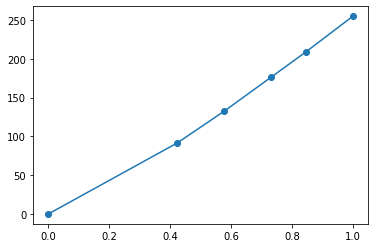

In [29]:
fig, ax = plt.subplots(1,1)
ax.plot(num_elecs, alch_pots_sum, '-o')

In [ ]:
# com = qml.Compound(xyz='/home/misa/datasets/qm9/dsgdb9nsd_001212.xyz')
# total_elec = com.nuclear_charges.sum()
# total_num_ve = 38
# num_ves = [8, 16, 24, 30, 38]
# alchemical_potentials = []
# e_homo = []
# e_lumo = []

# for num_ve in num_ves:
#     print(f'Calculating {num_ve}')
#     lam_val = num_ve/total_num_ve
#     # core_elec = com.nuclear_charges.sum() - total_num_ve

#     mol = pyscf.gto.Mole()
#     for ch, coords in zip(com.nuclear_charges, com.coordinates):
#         mol.atom.append([ch, coords])

#     mol.basis = 'def2-tzvp'
#     mol.charge = total_num_ve - num_ve
#     mol.verbose = 0
#     mol.build()

#     method = "HF"
#     if method not in ["CCSD", "HF"]:
#         raise NotImplementedError("Method %s not supported." % method)

#     deltaZ = -com.nuclear_charges*(1-lam_val)
#     includeonly = np.arange(len(mol.atom_coords()))


#     def add_qmmm(calc, mol, deltaZ):
#         mf = pyscf.qmmm.mm_charge(calc, mol.atom_coords()[includeonly]/ angstrom, deltaZ)

#         def energy_nuc(self):
#             q = mol.atom_charges().astype(np.float)
#             q[includeonly] += deltaZ
#             return mol.energy_nuc(q)

#         mf.energy_nuc = energy_nuc.__get__(mf, mf.__class__)

#         return mf

#     if method == "HF":
#         calc = add_qmmm(pyscf.scf.RHF(mol), mol, deltaZ)
#         hfe = calc.kernel(verbose=0)
#         dm1_ao = calc.make_rdm1()
#         total_energy = calc.e_tot
#     if method == "CCSD":
#         calc = add_qmmm(pyscf.scf.RHF(mol), mol, deltaZ)
#         hfe = calc.kernel(verbose=0)
#         mycc = pyscf.cc.CCSD(calc).run()
#         dm1 = mycc.make_rdm1()
#         dm1_ao = np.einsum("pi,ij,qj->pq", calc.mo_coeff, dm1, calc.mo_coeff.conj())
#         total_energy = mycc.e_tot

#     # GRIDLESS, as things should be ############################
#     # Total energy of SCF run

#     print("TOTAL_ENERGY", total_energy)

#     # Electronic EPN from electron density
#     alch_pot_tmp = []
#     for site in includeonly:
#         mol.set_rinv_orig_(mol.atom_coords()[site])
# #         print("ELECTRONIC_EPN", site, np.matmul(dm1_ao, mol.intor("int1e_rinv")).trace())
#         alch_pot_tmp.append(np.matmul(dm1_ao, mol.intor("int1e_rinv")).trace())
#     alchemical_potentials.append(alch_pot_tmp)
    
#     # energy of HOMO and LUMO
#     nocc = int((total_elec - mol.charge)/2)
#     e_homo.append(calc.mo_energy[nocc-1])
#     e_lumo.append(calc.mo_energy[nocc])